In [24]:
using LinearAlgebra
using FFTW
using Plots
plotlyjs()

Plots.PlotlyJSBackend()

In [25]:
struct out 
    input_fft :: Vector
    output_fft :: Vector
    adv :: Array
    diff :: Array
    T :: Array
    IC :: Array
end

In [26]:
# const domain = [2*pi, pi, 2]
# const dims = [128, 16, 128]
const Pr = 0.71
const nu = 1/180/Pr
const dt = 1e-4


const Nx = 16
const Nz = 32
const Ntheta = 129



const kx = 1
const ky = 0

0

In [27]:
x = LinRange(-pi, pi, Nx)
z = LinRange(0, 2, Nz)

const dx = x[2] - x[1]
const dz = z[2] - z[1]

xx = x .+ z'.*0
zz = x .* 0 .+ z'

u = zz .* (2 .- zz)
v = zz .* 0
w = zz .* 0;

In [28]:
function solver(u, v, w, T)
    adv = zeros(Float64, (Nx, Nz))
    adv[:, 2:end-1] .= u[:, 2:end-1].*(circshift(T[:, 2:end-1],[1, 0]) .- circshift(T[:, 2:end-1],[-1, 0]))./dx./2

    diff = zeros(Float64, (Nx, Nz))
    diff[:, 2:end-1] .= nu .*( circshift(T[:, 2:end-1],[1,0]) .- 2 .*T[:, 2:end-1] .+ circshift(T[:, 2:end-1],[-1,0]))./dx./dx .+ 
    nu .*(T[:, 3:end] .- 2 .*T[:, 2:end-1] .+ T[:, 1:end-2] ) ./dz./dz

    T_out = zeros(Float64, (Nx, Nz))
    T_out .= T .- dt .* adv .+ dt .* diff


    return T_out
end

solver (generic function with 1 method)

In [60]:
x = LinRange(0, 2*pi, 161)[1:end-1]
fft(cos.(x))

160-element Vector{ComplexF64}:
 -1.1405106167667888e-14 + 0.0im
                    80.0 - 1.6462892679321592e-14im
   2.711779497292719e-15 + 6.556702447474413e-15im
 -3.2475236937209556e-15 + 7.438000971160929e-16im
  1.1639851712514764e-15 - 5.978811779894988e-15im
  2.5323637367998553e-15 + 2.521584597720604e-15im
  2.9463241970533116e-15 + 3.969700144185568e-15im
 -2.3314683517128287e-15 + 2.1132600860414446e-15im
 -1.4071534969227076e-15 - 2.0455852989957125e-15im
  3.1214083546122566e-15 + 7.272377743134138e-16im
                         ⋮
   8.030066265359552e-15 - 9.5573017609229e-16im
 -1.4071534969227076e-15 + 2.0455852989957125e-15im
  -8.395976097747488e-16 + 1.088641092061016e-15im
   2.946324197053312e-15 - 3.969700144185567e-15im
   2.532363736799855e-15 - 2.521584597720604e-15im
  1.1639851712514768e-15 + 5.978811779894988e-15im
 -3.2475236937209556e-15 - 7.438000971160925e-16im
  2.7117794972927195e-15 - 6.556702447474414e-15im
                    80.0 + 1.7832924426

In [43]:
T .= 0
k = 2
T[:, k] .=  sin.(kx .* x)
fft(T[:, 2:end-1], 2)[1:3, 1:3]

[-1.2246467991473532e-16, -0.40673664307580004, -0.7431448254773942, -0.9510565162951536, -0.9945218953682734, -0.8660254037844388, -0.5877852522924731, -0.20791169081775918, 0.20791169081775918, 0.5877852522924731, 0.8660254037844385, 0.9945218953682733, 0.9510565162951536, 0.7431448254773939, 0.40673664307580004, 1.2246467991473532e-16]

3×3 Matrix{ComplexF64}:
 -1.22465e-16+0.0im  -1.22465e-16+0.0im  -1.22465e-16+0.0im
    -0.406737+0.0im     -0.406737+0.0im     -0.406737+0.0im
    -0.743145+0.0im     -0.743145+0.0im     -0.743145+0.0im

In [29]:
A = Array{ComplexF64, 2}(undef, Nz-2, Nz-2)
B = Array{ComplexF64, 2}(undef, Nz-2, Nz-2)

for k in range(2, Nz-1)
    T = zeros(Float64, (Nx, Nz))
    T_out = zeros(Float64, (Nx, Nz))

    T[:, k] .=  sin.(kx .* x)

    # input = [fft(T[:, k], 1)[kx+1] for k in range(1, Nz)]
    A[:, k-1] .= fft(T[:, 2:end-1], 2)[kx+1, :]


    T_out .= solver(u, v, w, T)

    # output = [fft(RHS[:, k], 1)[kx+1] for k in range(1, Nz)]
    B[:, k-1] .= fft(T_out[:, 2:end-1], 2)[kx+1, :]
end

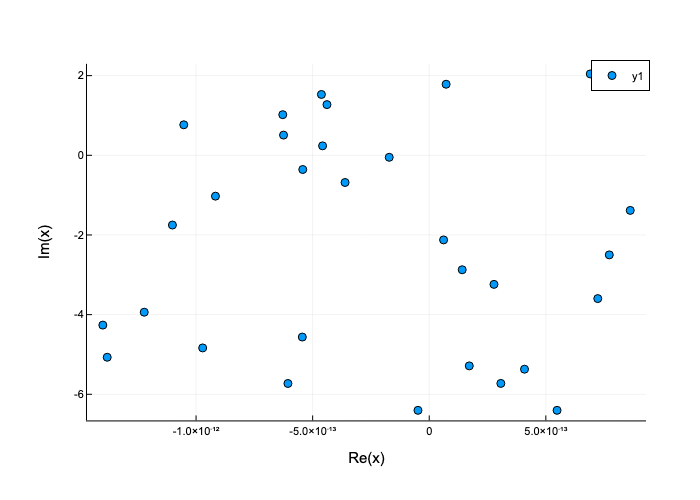

In [30]:
F = eigen(B,A)
omega = 1im.*log.(F.values)./dt
scatter(omega)

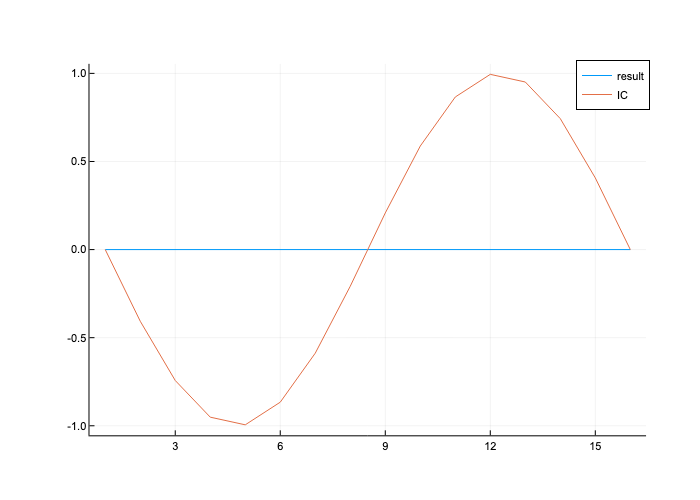

In [31]:
plot(result[:, 3, 3], label="result")
plot!(theta_ic[:, 3, 3], label="IC")

In [32]:
kk = 64
S = solver(u, v, w, theta_ic[:, :, kk])
plot(S.adv[:, kk])

ErrorException: type Array has no field adv

In [33]:
kk = 64
S = solver(u, v, w, theta_ic[:, :, kk])
plot(S.diff[:, kk])

ErrorException: type Array has no field diff